## Data preparation and vectorization

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


Data = np.zeros((400,10304))
cnt=0
paths = ["archive/s"+str(i) for i in range(1,41)]
# looping through the paths and adding flattened images (row matrices) to the Data matrix
for path in paths:
    files = os.listdir(path)
    for file in files:
        img = Image.open(path + "/" + file)
        np_img = np.array(img)
        np_img = np_img.flatten()
        Data[cnt]=np_img
        cnt+=1

# creating the labels vector
labels = np.zeros((400,1))
for i in range(1,41):
    labels[(i-1)*10:i*10] = i

# creating the training set and test set
# syntax explanation : [beginning:end:step]
training_set = Data[0:400:2]
test_set = Data[1:400:2]

# creating the training labels and test labels
training_labels = labels[0:400:2]
test_labels = labels[1:400:2]


print(training_set.shape)
print(test_set.shape)
print(training_labels.shape)
print(test_labels.shape)


(200, 10304)
(200, 10304)
(200, 1)
(200, 1)


## Data preprocessing

In [30]:
def data_processing(training_set,test_set):
    means=np.mean(training_set,axis=0)
    # we need to reshape the means vector to be a row vector to be able to use broadcasting
    means=means.reshape(1,10304)
    print(means.shape)
    centered_training_set=training_set-means
    print("centered_training_set.shape: " + str(centered_training_set.shape))
    centered_test_set=test_set-means
    print("centered_test_set.shape: " + str(centered_test_set.shape))
    # bias=True is used to divide by N instead of N-1 as we told in the lecture
    covariance_matrix=np.cov(centered_training_set.T,bias=True)
    print(covariance_matrix.shape)
    # we use eigh instead of eig because the covariance matrix is symmetric and won't have complex eigenvalues
    eigenvalues,eigenvectors=np.linalg.eigh(covariance_matrix)
    print(eigenvalues.shape)
    print(eigenvectors.shape)

    positions = eigenvalues.argsort()[::-1]
    sorted_eigenvalues = (eigenvalues[positions])
    sorted_eigenvectors = (eigenvectors[:,positions])
        
    return sorted_eigenvalues,sorted_eigenvectors,centered_training_set,centered_test_set



## PCA algorithm

In [33]:
alpha=[0.1 , 0.2 , 0.3 , 0.4, 0.5, 0.6, 0.7, 0.8,0.85, 0.9, 0.95, 0.96 , 0.97 , 0.98 , 0.99]
def get_pca(eigenvalues,eigenvectors, alpha):
    total = sum(eigenvalues)
    r = 0
    current_sum = 0
    while current_sum/total < alpha:
        current_sum += eigenvalues[r]
        r += 1
    new_space = eigenvectors[:, :r]    
    return new_space,r
sorted_eigenvalues,sorted_eigenvectors,centered_training_set,centered_test_set=data_processing(training_set,test_set)
scores=[]
pcs=np.zeros((len(alpha),1))
cnt=0
for i in alpha:
    new_space,pcs[cnt]=get_pca(sorted_eigenvalues,sorted_eigenvectors,i)
    new_training_set = np.dot(centered_training_set, new_space)
    new_test_set = np.dot(centered_test_set, new_space)
    #we use label.ravel() to convert the labels from a column vector to a row vector of shape (200,) instead of (200,1)
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(new_training_set, training_labels.ravel())
    scores.append(knn.score(new_test_set, test_labels.ravel()))
    cnt+=1



(1, 10304)
centered_training_set.shape: (200, 10304)
centered_test_set.shape: (200, 10304)
(10304, 10304)
(10304,)
(10304, 10304)


## showing the first 5 eigen-faces

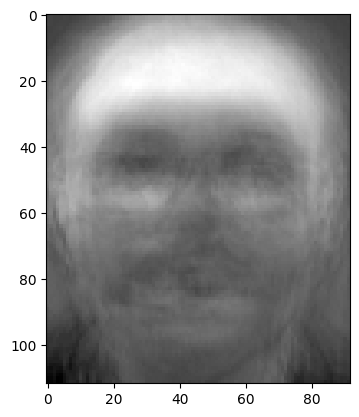

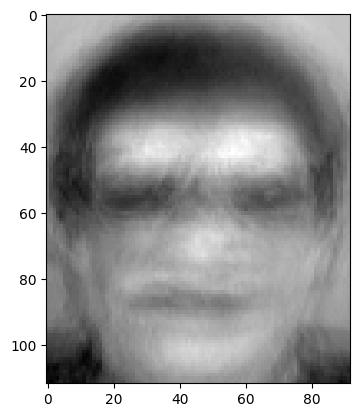

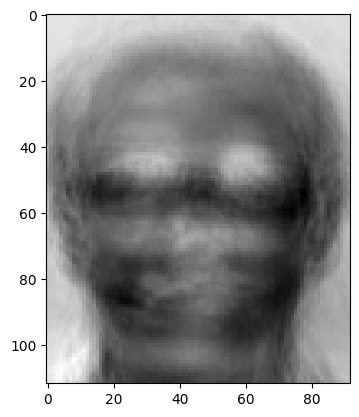

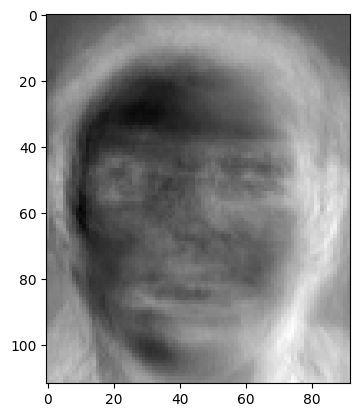

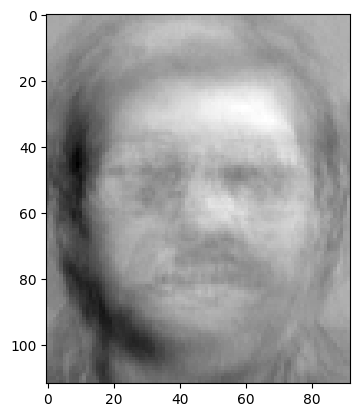

In [34]:
for i in range(5):
    plt.imshow(sorted_eigenvectors[:,i].reshape(112,92),cmap='gray')
    plt.show()


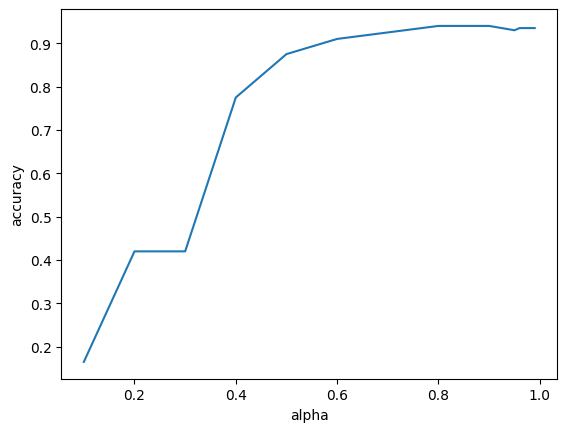

In [35]:
plt.plot(alpha, scores)
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.show()


according to this figure as alpha increases the accuracy increases 

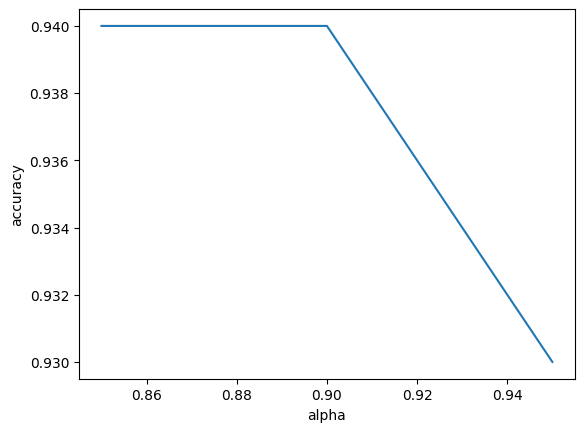

[0.165, 0.42, 0.42, 0.775, 0.875, 0.91, 0.925, 0.94, 0.94, 0.94, 0.93, 0.935, 0.935, 0.935, 0.935]


In [36]:
plt.plot(alpha[8:11], scores[8:11])
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.show()
print(scores)

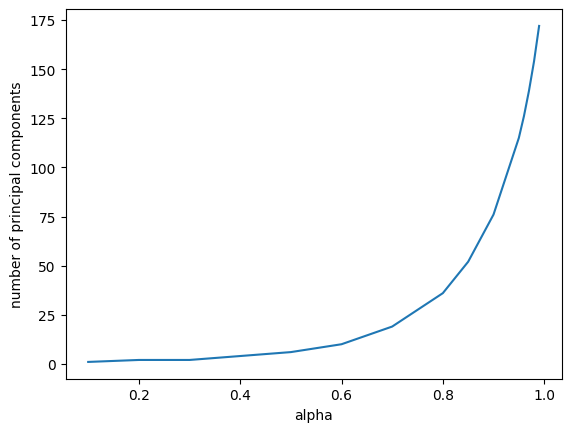

[[  1.]
 [  2.]
 [  2.]
 [  4.]
 [  6.]
 [ 10.]
 [ 19.]
 [ 36.]
 [ 52.]
 [ 76.]
 [115.]
 [126.]
 [139.]
 [154.]
 [172.]]


In [37]:
plt.plot(alpha, pcs)
plt.ylabel("number of principal components")
plt.xlabel("alpha")
plt.show()
print(pcs)


## Hyper Parameter tuning for PCA


In [38]:
# using last alpha value used in the previous part
# lessa hagarabha b a3la value lel alpha el bta3t a3la accuracy
k_values=[1,3,5,7]
accuracies=[]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(new_training_set, training_labels.ravel())
    print(knn.score(new_test_set, test_labels.ravel()))
    accuracies.append(knn.score(new_test_set, test_labels.ravel()))

0.935
0.855
0.785
0.705


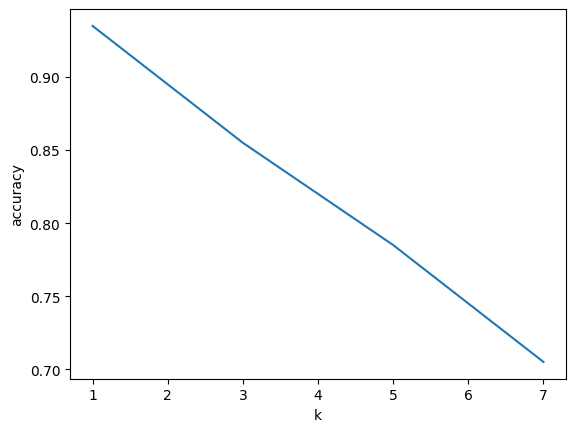

In [39]:
# Plotting the accuracies for different values of k
plt.plot(k_values, accuracies)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

according to this figure using 1 neighbour is the best choice

## Changing percentage of training and test split

In [40]:
bonus_training_set = np.zeros((280,10304))
bonus_training_labels = np.zeros((280,1))
bonus_test_set = np.zeros((120,10304))
bonus_test_labels = np.zeros((120,1))
tr=0
ts=0
for i in range(0,400):
    if(i%10<7):
        bonus_training_set[tr]=Data[i]
        bonus_training_labels[tr]=labels[i]
        tr+=1
    else:
        bonus_test_set[ts]=Data[i]
        bonus_test_labels[ts]=labels[i]
        ts+=1                      

## applying PCA on these splits

In [50]:
bonus_sorted_eigenvalues,bonus_sorted_eigenvectors,bonus_centered_training_set,bonus_centered_test_set=data_processing(bonus_training_set,bonus_test_set)
k_values=[1,3,5,7]
bonus_accuracies=[]


alpha=[0.1 , 0.2 , 0.3 , 0.4, 0.5, 0.6, 0.7, 0.8,0.85, 0.9, 0.95, 0.96 , 0.97 , 0.98 , 0.99]
bonus_pcs=np.zeros((len(alpha),1))
bonus_scores=[]
cnt=0
for i in alpha:
    bonus_new_space,bonus_pcs[cnt]=get_pca(bonus_sorted_eigenvalues,bonus_sorted_eigenvectors,i)
    bonus_new_training_set = np.dot(bonus_centered_training_set, bonus_new_space)
    bonus_new_test_set = np.dot(bonus_centered_test_set, bonus_new_space)
    #we use label.ravel() to convert the labels from a column vector to a row vector of shape (200,) instead of (200,1)
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(bonus_new_training_set, bonus_training_labels.ravel())
    bonus_scores.append(knn.score(bonus_new_test_set, bonus_test_labels.ravel()))
    cnt+=1


(1, 10304)
centered_training_set.shape: (280, 10304)
centered_test_set.shape: (120, 10304)
(10304, 10304)
(10304,)
(10304, 10304)


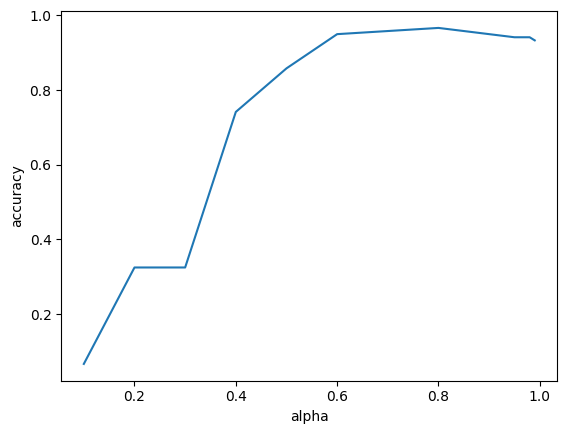

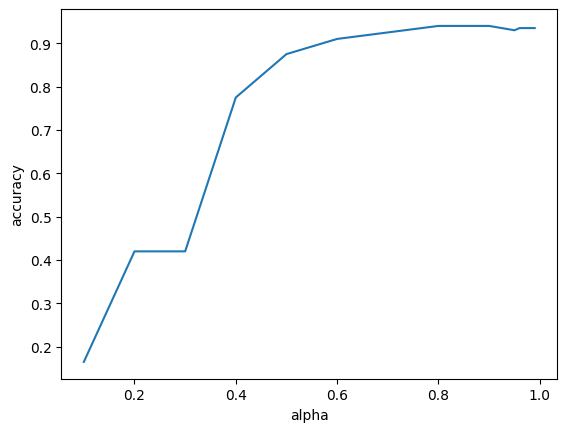

In [57]:
# plot bonus scores vs alpha
plt.plot(alpha,bonus_scores)
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.show()
plt.plot(alpha,scores[0:15])
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.show()

In [64]:
print(bonus_pcs.ravel())
size=bonus_pcs.shape[0]
for i in range(size):
    print(str(scores[i])+"    --    "+str(bonus_scores[i]))


[  1.   2.   2.   4.   6.  10.  19.  38.  57.  89. 145. 161. 180. 204.
 233.]
0.165    --    0.06666666666666667
0.42    --    0.325
0.42    --    0.325
0.775    --    0.7416666666666667
0.875    --    0.8583333333333333
0.91    --    0.95
0.925    --    0.9583333333333334
0.94    --    0.9666666666666667
0.94    --    0.9583333333333334
0.94    --    0.95
0.93    --    0.9416666666666667
0.935    --    0.9416666666666667
0.935    --    0.9416666666666667
0.935    --    0.9416666666666667
0.935    --    0.9333333333333333


as shown accuracies have increased by splitting data int 70% training split and 30% test split